In [4]:
from vnstock import Vnstock
from backtesting import Backtest, Strategy
import pandas as pd
import pandas_ta as ta

# Load HPG data from vnstock
stock = Vnstock().stock(symbol='HPG', source='VCI')
df = stock.quote.history(start='2017-01-01', end='2025-04-01', interval='1D')

df.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define strategy class
class ADXTrendStrategy(Strategy):
    adx_period = 14
    sma_period = 50

    def init(self):
        df = self.data.df

        df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'], length=self.adx_period)['ADX_14']
        df['SMA'] = ta.sma(df['Close'], length=self.sma_period)

        self.adx = self.I(lambda: df['ADX'])
        self.sma = self.I(lambda: df['SMA'])

    def next(self):
        price = self.data.Close[-1]
        adx = self.adx[-1]
        sma = self.sma[-1]

        if not self.position and adx > 25 and price > sma:
            self.buy()

        elif self.position:
            if adx < 20 or price < sma:
                self.position.close()

# Run backtest
bt = Backtest(df, ADXTrendStrategy, cash=100_000, commission=0, exclusive_orders=True)
stats = bt.run()

bt.plot()


Backtest.run:   0%|          | 0/2009 [00:00<?, ?bar/s]

GridPlot(id='p1801', ...)

In [5]:
print(stats)

Start                     2017-01-03 00:00:00
End                       2025-04-01 00:00:00
Duration                   3010 days 00:00:00
Exposure Time [%]                    32.54007
Equity Final [$]                    314557.15
Equity Peak [$]                     352264.89
Return [%]                          214.55715
Buy & Hold Return [%]               354.54545
Return (Ann.) [%]                    15.05704
Volatility (Ann.) [%]                22.08542
CAGR [%]                             10.06972
Sharpe Ratio                          0.68176
Sortino Ratio                         1.21343
Calmar Ratio                           0.5644
Alpha [%]                            99.23889
Beta                                  0.32526
Max. Drawdown [%]                   -26.67788
Avg. Drawdown [%]                    -4.63605
Max. Drawdown Duration      757 days 00:00:00
Avg. Drawdown Duration       74 days 00:00:00
# Trades                                   25
Win Rate [%]                      

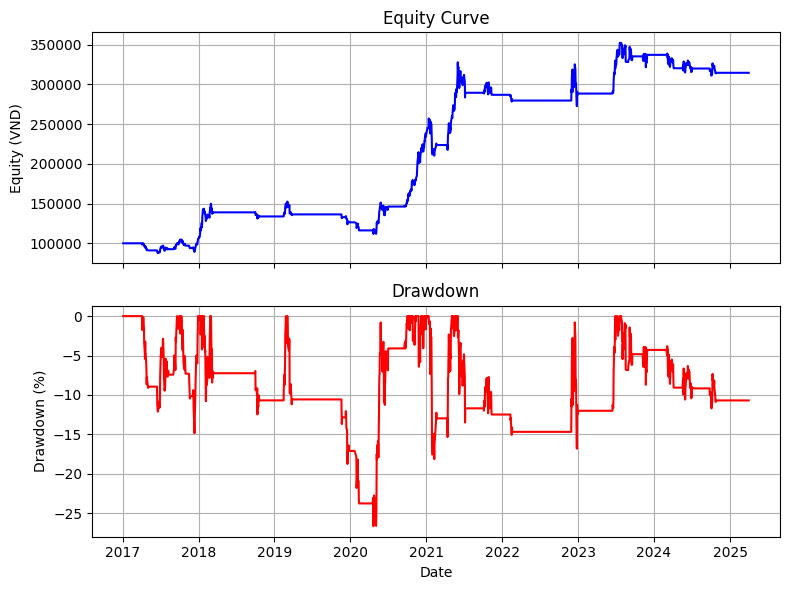

In [6]:
import matplotlib.pyplot as plt

equity_curve = stats._equity_curve.copy()

# Convert DrawdownPct to negative
equity_curve['DrawdownPct'] = -equity_curve['DrawdownPct']*100

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot Equity curve
axes[0].plot(equity_curve.index, equity_curve['Equity'], color='blue')
axes[0].set_ylabel('Equity (VND)')
axes[0].set_title('Equity Curve')
axes[0].grid(True)

# Plot Drawdown curve
axes[1].plot(equity_curve.index, equity_curve['DrawdownPct'], color='red')
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_xlabel('Date')
axes[1].set_title('Drawdown')
axes[1].grid(True)

plt.tight_layout()
plt.show()
